In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import rediscovery_rate
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import results of network proximity based screen of ChEMBL: import info columns

In [2]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
usecols = range(6)
merged = pd.read_csv(fpath, index_col=0, skiprows=1, usecols=usecols).rename_axis('drug_chembl_id', axis=0)

Import results of network proximity based screen of ChEMBL: import ranks

In [3]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
sel_gsets = ['knowledge', 'TWAS2+', 'agora2+', 'AD DE APOE3-APOE3', 'AD DE APOE4-APOE4', 'APOE3-4 DE neuron', 'APOE3-4 DE astrocyte', 'APOE3-4 DE microglia']
merged_ranks = pd.read_csv(fpath, index_col=0, header=[0, 1]).rename_axis('drug_chembl_id', axis=0).xs('rank', axis=1, level=1)[sel_gsets]

Import the table containing the clinical phase for drug-indication pairs

In [4]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
indications = pd.read_csv(fpath, index_col='drug_chembl_id')
# D000544 is Alzheimer disease
mp4ad = indications.loc[indications.mesh_id == 'D000544', ['max_phase_for_ind']].rename({'max_phase_for_ind': 'max_phase_for_AD'}, axis=1)

Import additional info on ChEMBL drugs such as BBB permeability

In [5]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
info_bbb = pd.read_csv(fpath, index_col=0).drop(['drug_name'], axis=1)

Import the list of aggregated ranks

In [6]:
fpath = '../../results/2022-01-14-rank-aggregation/aggregated-ranks.csv'
agg_ranks = pd.read_csv(fpath, index_col='rank')
top_drugs = pd.DataFrame({'aggregate rank': agg_ranks.index}, index=agg_ranks.MC3).rename_axis('drug_chembl_id', axis=0)

Merge all above into a single data frame called `drugs`

In [7]:
drugs = pd.merge(merged, info_bbb, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, mp4ad, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, top_drugs, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, merged_ranks, how='left', on='drug_chembl_id')
drugs = drugs.sort_values('aggregate rank')
drugs.to_csv('../../results/2022-01-14-top-drugs/ranked-drugs.csv')
drugs.iloc[:200].to_csv('../../results/2022-01-14-top-drugs/ranked-drugs-top-200.csv')
drugs.drop(drugs.loc[drugs.max_phase_for_AD == 0].index).dropna(subset=['max_phase_for_AD']).to_csv('../../results/2022-01-14-top-drugs/ranked-drugs-top-developed4AD.csv')
drugs

,drug_name,max_phase,indication_class,uniprot_name,target_name,standard_inchi,logBB,BBB+/BBB-,BBB confidence group,max_phase_for_AD,aggregate rank,knowledge,TWAS2+,agora2+,AD DE APOE3-APOE3,AD DE APOE4-APOE4,APOE3-4 DE neuron,APOE3-4 DE astrocyte,APOE3-4 DE microglia
drug_chembl_id,,,,,,,,,,,,,,,,,,,
CHEMBL477772,PAZOPANIB,4,NaN,BMR1B|PK3CD|PLK4|STK25|P3C2B|RIOK3|MP2K7|CHK1|...,Bone morphogenetic protein receptor type-1B|PI...,InChI=1S/C21H23N7O2S/c1-13-5-6-15(11-19(13)31(...,NaN,NaN,NaN,NaN,1.0,97,24,72,1187,25,18,1632,1833
CHEMBL491473,CEDIRANIB,3,NaN,CDC7|PK3CD|EF2K|PLK4|STK25|P3C2B|RIOK3|MP2K7|I...,Cell division cycle 7-related protein kinase|P...,InChI=1S/C25H27FN4O3/c1-16-12-17-19(29-16)6-7-...,NaN,NaN,NaN,NaN,2.0,106,41,52,1274,22,37,1164,2035
CHEMBL939,GEFITINIB,4,NaN,CDC7|EF2K|PLK4|STK25|P3C2B|CTRO|RIOK3|MP2K7|IK...,Cell division cycle 7-related protein kinase|S...,InChI=1S/C22H24ClFN4O3/c1-29-20-13-19-16(12-21...,-0.5,BBB+,A,NaN,3.0,66,18,90,959,11,83,1450,2026
CHEMBL446452,ARUNDINE,3,NaN,RGS4|GPR84,Regulator of G-protein signaling 4|G-protein c...,InChI=1S/C17H14N2/c1-3-7-16-14(5-1)12(10-18-16...,NaN,NaN,NaN,NaN,4.0,1323,816,18,14,14,5,1228,1196
CHEMBL296306,LACTULOSE,4,Laxative,RGS4,Regulator of G-protein signaling 4,InChI=1S/C12H22O11/c13-1-4-6(16)7(17)8(18)11(2...,NaN,NaN,NaN,NaN,5.0,1321,815,15,15,16,7,1227,1195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL236593,TELCAGEPANT,3,NaN,RAMP1|CALCA|CALRL,"Calcitonin-gene-related peptide receptor, CALC...",InChI=1S/C26H27F5N6O3/c27-18-4-1-3-17(21(18)28...,NaN,NaN,NaN,NaN,NaN,2409,2412,2225,1653,1657,2413,2411,2404
CHEMBL3716057,GEFAPIXANT,3,NaN,P2RX3|P2RX2,P2X purinoceptor 3|P2X2/P2X3 heterotrimeric re...,InChI=1S/C14H19N5O4S/c1-7(2)8-4-10(22-3)12(24(...,NaN,NaN,NaN,NaN,NaN,2410,2374,2410,2411,2413,2405,2412,2410
CHEMBL770,TOLAZOLINE,4,Vasodilator (peripheral),LMNA|CP1A2|ADA1D|5HT1D|5HT1B|ADA1A|ADA1B|TAAR1,Prelamin-A/C|Cytochrome P450 1A2|Adrenergic re...,InChI=1S/C10H12N2/c1-2-4-9(5-3-1)8-10-11-6-7-1...,NaN,BBB+,C,NaN,NaN,2411,2396,2413,2087,895,2209,2290,2178


## Differences between ranked lists

The plot below shows how individual input ranked lists differ from the output aggregate ranked list of the MC3 rank aggregation algorithm.

['named-figure/rank-diff.png', 'named-figure/rank-diff.pdf']

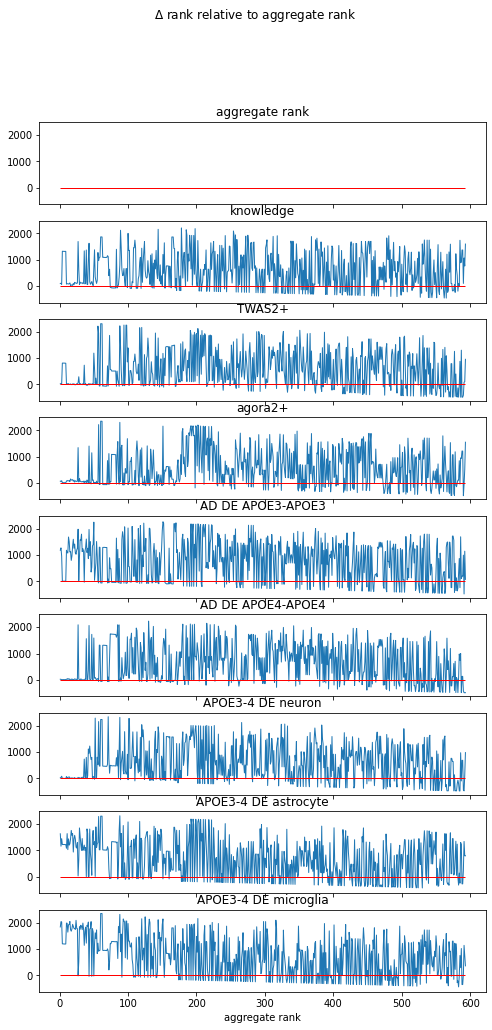

In [8]:
def rank_diff_plot(xlim=None):
    fig, ax = plt.subplots(len(sel_gsets) + 1, 1, figsize=(8, 16), sharex=True, sharey=True)
    for gset, axi in zip(['aggregate rank'] + sel_gsets, ax):
        if gset != 'aggregate rank':
            axi.plot(drugs['aggregate rank'], drugs[gset] - drugs['aggregate rank'], linewidth=1)
        axi.set_title(gset)
        axi.hlines(0, 0, drugs['aggregate rank'].max(), color='red', linewidth=1, linestyle='solid')
        if xlim is not None:
            axi.set_xlim(xlim)
    axi.set_xlabel('aggregate rank')
    fig.suptitle(r'$\Delta$ rank relative to aggregate rank')
    return((fig, ax))

fig, ax = rank_diff_plot()
attila_utils.savefig(fig, 'rank-diff')

Focussing on the top 100 drugs w.r.t the aggregate ranking shows that the top $\approx 35$ drugs correspond to the top $\approx 35$ of agora2+, AD DE APOE4-APOE4 and APOE3-4 DE neuron and to mainly the top $\approx 35$ of TWAS2+.  In other words, these four gene sets have the greatest impact on the very top of the aggregate ranking.

['named-figure/rank-diff-100.png', 'named-figure/rank-diff-100.pdf']

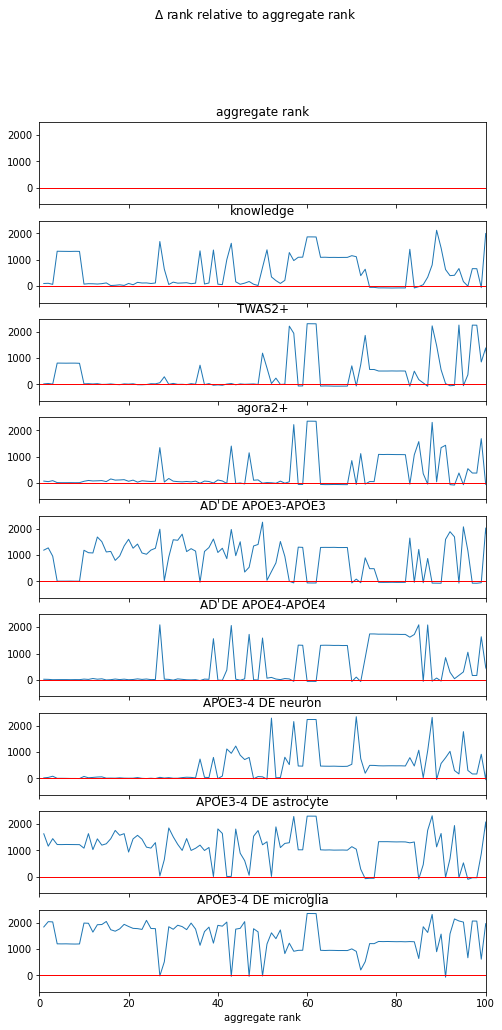

In [9]:
fig, ax = rank_diff_plot(xlim=(0, 100))
attila_utils.savefig(fig, 'rank-diff-100')

['named-figure/separate-aggregate-ranks-heatmap.png',
 'named-figure/separate-aggregate-ranks-heatmap.pdf']

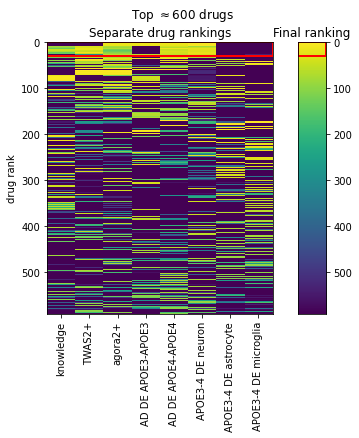

In [10]:
def rank_imshow(topk=None, drugs=drugs, rect_height=30):
    width_ratios = [8, 1]
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': width_ratios}, figsize=(5, 5))
    data = drugs.dropna(subset=['aggregate rank'], axis=0).loc[:, 'aggregate rank':]
    vmax = data.shape[0]
    data = data.iloc[:topk] if topk is not None else data
    ax[0].imshow(data.drop('aggregate rank', axis=1), aspect='auto', interpolation='none', cmap='viridis_r', vmin=0, vmax=vmax)
    ax[0].set_title('Separate drug rankings')
    ax[1].imshow(data[['aggregate rank']], aspect='auto', interpolation='none', cmap='viridis_r', vmin=0, vmax=vmax)
    ax[1].set_title('Final ranking')
    ax[0].set_xticks(range(drugs.loc[:, 'knowledge':].shape[1]))
    ax[0].set_xticklabels(drugs.loc[:, 'knowledge':].columns, rotation=90)
    ax[1].set_xticks([])
    ax[1].tick_params(right=True, left=False, labelright=True, labelleft=False)
    if topk is not None:
        [axi.set_yticks(range(topk)) for axi in ax]
        [axi.set_yticklabels(drugs.loc[data.index, 'drug_name'], fontsize=8) for axi in ax]
    else:
        ax[0].set_ylabel('drug rank')
#        [axi.set_ylabel('drug rank') for axi in ax]
    rects = [Rectangle((-0.5, -0.5), width=w, height=rect_height) for w in width_ratios]
    pc = [PatchCollection([r], edgecolor='red', facecolor='none', linewidth=2, linestyle='solid') for r in rects]
    [axi.add_collection(p) for axi, p in zip(ax, pc)]
    return((fig, ax))

rect_height = 30
fig, ax = rank_imshow(rect_height=rect_height)
fig.suptitle(r'Top $\approx 600$ drugs')
attila_utils.savefig(fig, 'separate-aggregate-ranks-heatmap')

['named-figure/separate-aggregate-ranks-heatmap-topk.png',
 'named-figure/separate-aggregate-ranks-heatmap-topk.pdf']

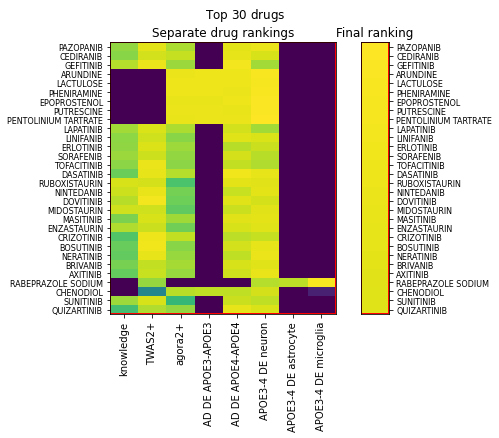

In [11]:
fig, ax = rank_imshow(topk=rect_height, rect_height=rect_height)
fig.suptitle(r'Top $30$ drugs')
attila_utils.savefig(fig, 'separate-aggregate-ranks-heatmap-topk')

## More indications

Here we look at common indications, including *Alzheimer Disease*, defined as indications for which at least 100 drugs exist in some ($\ge 1$) clinical phase.  One key data frame is `mesh`.

In [12]:
fpath = '../../results/2021-12-13-chembl-drug-info/drug-mesh.csv'
mesh = pd.read_csv(fpath, index_col=['drug_chembl_id', 'mesh_id']).sort_index(0, level='mesh_id').dropna()
# remove rare indications
min_freq_ind = 100
mesh_id_freq = mesh.index.get_level_values('mesh_id').value_counts()
common_ind = set(mesh_id_freq.loc[mesh_id_freq >= min_freq_ind].index)
rare_ind = set(mesh_id_freq.index).difference(common_ind)
mesh = mesh.drop(rare_ind, axis=0, level='mesh_id')
mesh = mesh.sort_values('mesh_heading')
# remove unscreened drugs
#drugs2remove = set(mesh.index.get_level_values('drug_chembl_id')).difference(set(drugs.index))
#mesh = mesh.drop(drugs2remove, axis=0, level='drug_chembl_id')
mesh_heading = mesh.mesh_heading.droplevel('drug_chembl_id', axis=0)
mesh_heading = mesh_heading.loc[~mesh_heading.index.duplicated()].sort_values()
mesh.head()

,,drug_name,mesh_heading,max_phase_for_ind
drug_chembl_id,mesh_id,,,
CHEMBL1017,D000544,TELMISARTAN,Alzheimer Disease,2.0
CHEMBL521,D000544,IBUPROFEN,Alzheimer Disease,1.0
CHEMBL517427,D000544,NILVADIPINE,Alzheimer Disease,3.0
CHEMBL502,D000544,DONEPEZIL,Alzheimer Disease,3.0
CHEMBL493,D000544,BROMOCRIPTINE,Alzheimer Disease,1.0


In [13]:
mesh_phase = mesh.max_phase_for_ind.unstack()
drugs_mesh = pd.merge(drugs, mesh_phase, how='left', on='drug_chembl_id')
drugs_mesh_heading = drugs_mesh.rename(mesh_heading.to_dict(), axis=1)
#drugs_mesh_heading.head()

## Relative rediscovery rate for an indication

Let $X$ denote the top-$k$ drugs or the bottom $l$ drugs.  Definition of **average phase for AD** for drugs in $X$:
\begin{eqnarray}
\bar{\phi_X} &=& \frac{1}{|X|} \sum_{d \in X} \phi_d \\
|X| &=& 
  \begin{cases} 
   k   & \text{if } X = \text{top-}k \text{ drugs} \\
   l & \text{if } X = \text{bottom-}l \text{ drugs}
  \end{cases}
\end{eqnarray}

Definition of **relative rediscovery rate for AD**:
\begin{equation}
\frac{\bar{\phi}_{\text{top-}k \text{ drugs}}}{\bar{\phi}_{\text{bottom-}l \text{ drugs}}}
\end{equation}

#### Notes

* the top $0 < k \le n_\text{max agg rank} = 605$ may be adjusted to see the effect of $k$ on the top:bottom phase ratio for AD; see graph below
* the bottom $l$ is fixed at $l = n_\text{all drugs} - n_\text{max agg rank} = 1808$, see `top_bottom` function below

In [14]:
def top_bottom(drugs=drugs, topk=100, min_max_phase_for_ind=1, ind_col='max_phase_for_AD'):
    bottoml = drugs['aggregate rank'].count()
    #bottomk = len(drugs) - topk
    df = drugs.copy()
    df['tested4AD'] = drugs[ind_col] >= min_max_phase_for_ind
    top = df.iloc[:topk]
    bottom = df.iloc[-bottoml:]
    top_avg, bottom_avg = [df.loc[df['tested4AD'], ind_col].sum() / xk for df, xk in zip([top, bottom], [topk, bottoml])]
    ratio = top_avg / bottom_avg
    return(ratio)

In [15]:
print('bottom l drugs:', len(drugs['aggregate rank']) - drugs['aggregate rank'].count())

bottom l drugs: 1820


Depending on how we set the $k$ of the top-$k$ drugs, the top:bottom clinical phase ratio for Alzheimer's is around 2--3

['named-figure/top-bottom-ratio-top-k.png',
 'named-figure/top-bottom-ratio-top-k.pdf']

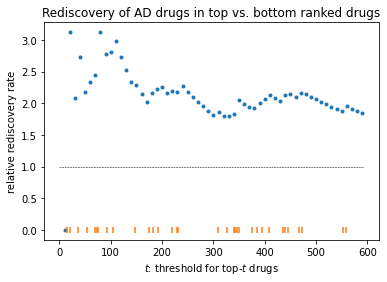

In [16]:
def top_bottom_plot(ax, drugs_mesh, min_max_phase_for_ind=1, ind_col='max_phase_for_AD', title=None):
    step = 10
    topks = np.arange(start=step, stop=len(agg_ranks), step=step)
    ORs = [top_bottom(drugs_mesh, topk=k, min_max_phase_for_ind=min_max_phase_for_ind, ind_col=ind_col) for k in topks]
    ax.scatter(x=topks, y=ORs, marker='.')
    ranks = drugs_mesh.loc[drugs_mesh[ind_col] >= 1, 'aggregate rank'].dropna()
    ax.scatter(x=ranks, y=[0] * len(ranks), marker='|', color='C1')
    ax.set_xlabel(r'$t$: threshold for top-$t$ drugs')
    ax.set_ylabel('relative rediscovery rate')
    title = ind_col if title is None else title
    ax.set_title(title)
    ax.hlines(1, 0, len(agg_ranks), color='black', linewidth=0.5, linestyle='dashed')
    return(ax)

fig, ax = plt.subplots()
ax = top_bottom_plot(ax, drugs_mesh, min_max_phase_for_ind=1, ind_col='max_phase_for_AD')
ax.set_title(r'Rediscovery of AD drugs in top vs. bottom ranked drugs')
attila_utils.savefig(fig, 'top-bottom-ratio-top-k')

### Rel. rediscovery rate given input AD set

The analysis below shows that the relative rediscovery rate varies across input AD gene sets.  The highest rate is observed for knowledge, wich has two complementary interpretations:

1. the knowledge based AD genes are the best drug targets
1. the knowledge based AD genes are the most enriched with genes previously considered as AD drug targets

['named-figure/rel-rediscovery-rate-all-inputs.png',
 'named-figure/rel-rediscovery-rate-all-inputs.pdf']

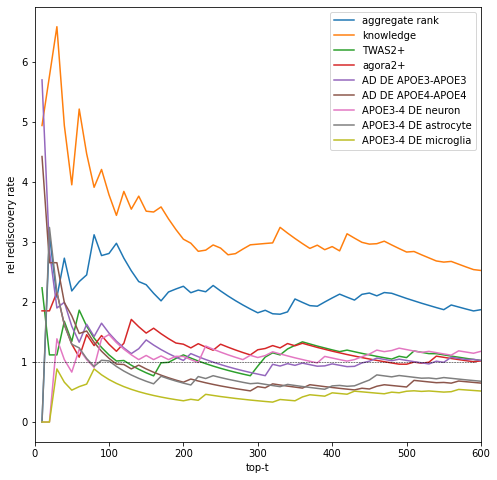

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
for ADset in drugs.columns[-9:]:
    rediscovery_rate.rel_rediscovery_rates(drugs.sort_values(ADset), bottoml=593).plot(kind='line', x='top-t', y='rel rediscovery rate', ax=ax, label=ADset)

ax.set_ylabel('rel rediscovery rate')
ax.set_xlim(0, 600)
ax.hlines(1, 0, len(agg_ranks), color='black', linewidth=0.5, linestyle='dashed')
attila_utils.savefig(fig, 'rel-rediscovery-rate-all-inputs')

['named-figure/avg-rel-rediscovery-rate-all-inputs.png',
 'named-figure/avg-rel-rediscovery-rate-all-inputs.pdf']

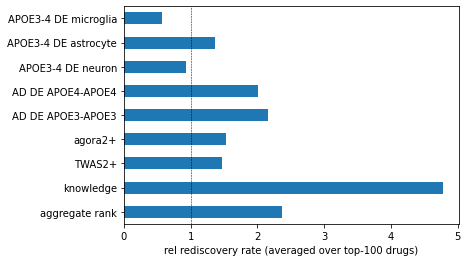

In [18]:
def get_avg_rel_rediscovery_rate(drugs, top_t=100):
    def helper(ADset, top_t):
        df = rediscovery_rate.rel_rediscovery_rates(drugs.sort_values(ADset), bottoml=593)
        rrr_avg = df.loc[df['top-t'] <= top_t, 'rel rediscovery rate'].sum() / top_t * 10
        return(rrr_avg)
    d = {ADset: helper(ADset, top_t) for ADset in drugs.columns[-9:]}
    rrrs = pd.DataFrame(d, index=['rate']).transpose()
    fig, ax = plt.subplots()
    rrrs.plot(kind='barh', ax=ax)
    ax.vlines(1, -0.5, 8.5, color='black', linewidth=0.5, linestyle='dashed')
    ax.set_xlabel('rel rediscovery rate (averaged over top-{} drugs)'.format(str(top_t)))
    ax.get_legend().remove()
    return((fig, ax, rrrs))

fig, ax, rrrs = get_avg_rel_rediscovery_rate(drugs, top_t=100)
attila_utils.savefig(fig, 'avg-rel-rediscovery-rate-all-inputs')

['named-figure/avg-rel-rediscovery-rate-all-inputs-200.png',
 'named-figure/avg-rel-rediscovery-rate-all-inputs-200.pdf']

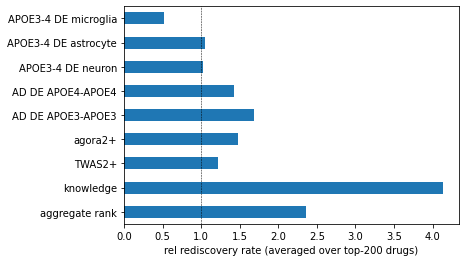

In [19]:
fig, ax, rrrs = get_avg_rel_rediscovery_rate(drugs, top_t=200)
attila_utils.savefig(fig, 'avg-rel-rediscovery-rate-all-inputs-200')

['named-figure/top-bottom-ratio-top-k-multi-1.png',
 'named-figure/top-bottom-ratio-top-k-multi-1.pdf']

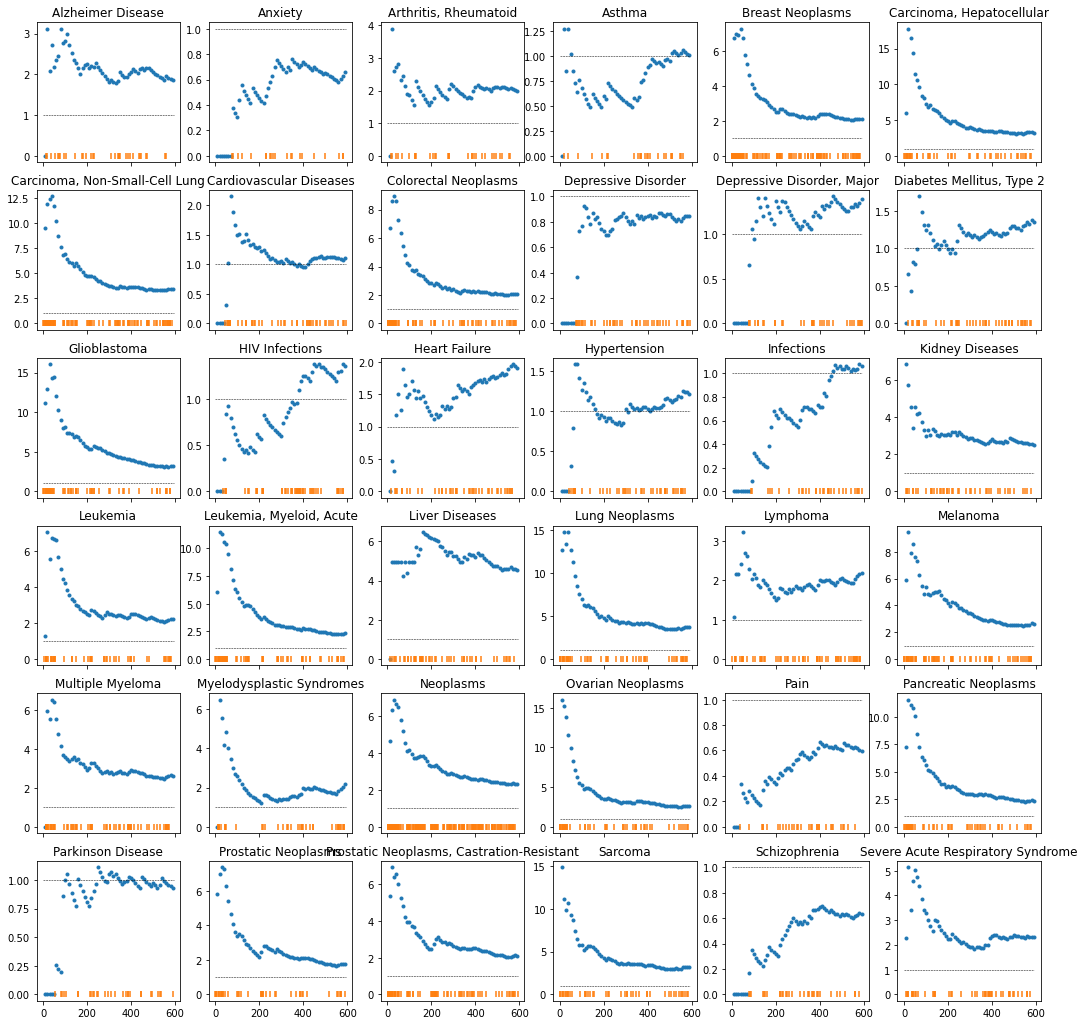

In [20]:
%%capture --no-display

def multi_top_bottom_plot(min_max_phase_for_ind):
    ncol = 6
    fig, ax = plt.subplots(np.int64(np.ceil(len(mesh_heading) / ncol)), ncol, figsize=(18, 18), sharex=True, sharey=False)
    for axi, ind in zip(ax.flatten(), mesh_heading.index):
        axi = top_bottom_plot(axi, drugs_mesh, min_max_phase_for_ind=min_max_phase_for_ind, ind_col=ind, title=mesh_heading.loc[ind])
        axi.set_xlabel('')
        axi.set_ylabel('')
    return((fig, ax))

fig, ax = multi_top_bottom_plot(1)
attila_utils.savefig(fig, 'top-bottom-ratio-top-k-multi-1')

['named-figure/top-bottom-ratio-top-k-multi-3.png',
 'named-figure/top-bottom-ratio-top-k-multi-3.pdf']

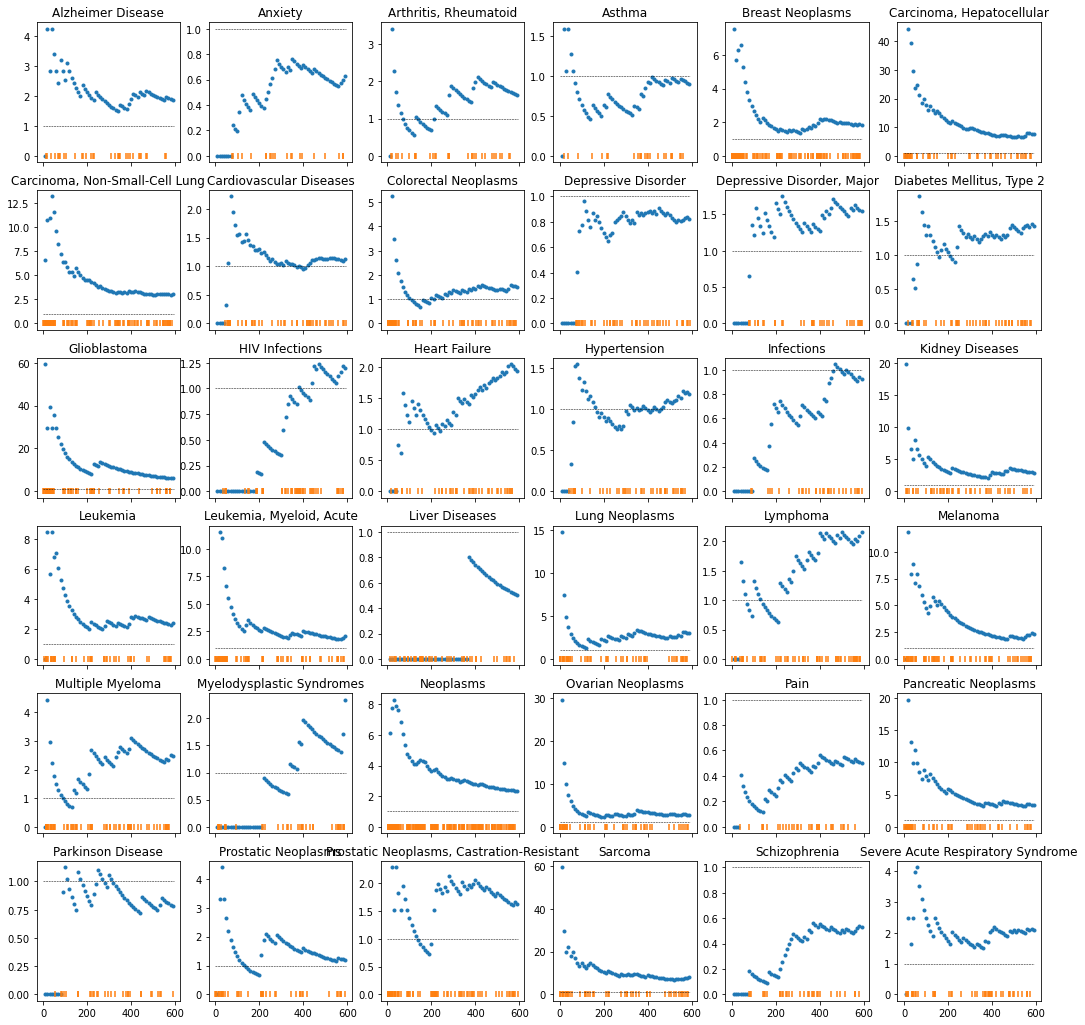

In [21]:
%%capture --no-display
fig, ax = multi_top_bottom_plot(3)
attila_utils.savefig(fig, 'top-bottom-ratio-top-k-multi-3')

In [22]:
%connect_info

{
  "shell_port": 54447,
  "iopub_port": 54448,
  "stdin_port": 54449,
  "control_port": 54451,
  "hb_port": 54450,
  "ip": "127.0.0.1",
  "key": "669cfef9-534432eb921ed02d95858f14",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6ae5eed7-5392-4b77-ad2c-f29c115f4c5b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
